<a href="https://colab.research.google.com/github/Whaleman0423/Deep_Learning_model/blob/main/transfer_learning_keras1105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import pandas as pd

# Define Parameters

In [28]:
num_classes = 3
IMG_SIZE = 224

# download from google drive or upload file by yourself

In [29]:
!gdown --id '1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4
To: /content/retina-dataset.zip
100% 35.1M/35.1M [00:00<00:00, 82.9MB/s]


# unzip dataset file

In [30]:
!unzip -q retina-dataset.zip

replace retina-test/10017_left.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Data Visualization

In [31]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

In [32]:
paths

['retina-train/3123_left_0.jpeg',
 'retina-train/12918_left_0.jpeg',
 'retina-train/29960_left_2.jpeg',
 'retina-train/38447_right_1.jpeg',
 'retina-train/23160_right_0.jpeg',
 'retina-train/23433_left_2.jpeg',
 'retina-train/23933_left_0.jpeg',
 'retina-train/1600_right_0.jpeg',
 'retina-train/23829_right_0.jpeg',
 'retina-train/6205_right_0.jpeg',
 'retina-train/36909_right_0.jpeg',
 'retina-train/16802_right_2.jpeg',
 'retina-train/27414_right_0.jpeg',
 'retina-train/29730_left_1.jpeg',
 'retina-train/29595_right_0.jpeg',
 'retina-train/37332_right_2.jpeg',
 'retina-train/32874_left_0.jpeg',
 'retina-train/19115_right_0.jpeg',
 'retina-train/22456_right_0.jpeg',
 'retina-train/17668_right_0.jpeg',
 'retina-train/21540_right_1.jpeg',
 'retina-train/37677_left_0.jpeg',
 'retina-train/6377_right_1.jpeg',
 'retina-train/23395_left_1.jpeg',
 'retina-train/33074_left_0.jpeg',
 'retina-train/43657_left_0.jpeg',
 'retina-train/35583_right_0.jpeg',
 'retina-train/3371_left_2.jpeg',
 'retina-

retina-train/44146_right_1.jpeg


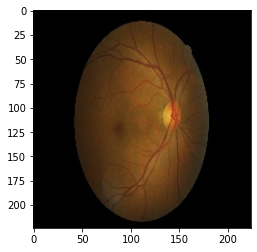

In [33]:
idx = np.random.randint(0, len(paths), size=1)[0]  # 隨機取一張圖
# idx
path = paths[idx]
# print(path.shape)
img = cv2.imread(path)
plt.imshow(img[:, :, ::-1])
print(path)
# print(img)

In [34]:
# print(type(img))  # 看看img 的樣子
# print(img.shape)
# for i in img:
#   print(i)
# # print(img)

######Histogram Equalization 直方圖均衡化 是用於將一幅圖像的像素的色彩強度平均分佈，令圖像提高對比度及擁有更豐富的色彩，而且能使圖像不會過暗或過亮，常用於過暗或過亮的圖片美化。

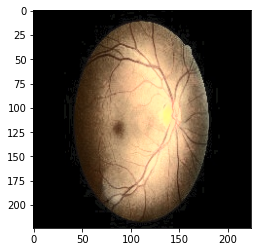

In [35]:
# Histogram Equalization
img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# print(img_y_cr_b.shape)
y, cr, cb = cv2.split(img_y_cr_cb)

# Applying equalize Hist operation on Y channel.
y_eq = cv2.equalizeHist(y)
img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
# img_y_cr_cb_eq.shape
img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2RGB)
plt.imshow(img_rgb_eq)

In [36]:
# os.path.split()  函數將文件路徑和文件名稱分開
all_filenames = [os.path.split(p)[1] for p in paths] # path => ***.jpeg
print(all_filenames[:3])

all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames]
print(all_cls[:3])

['3123_left_0.jpeg', '12918_left_0.jpeg', '29960_left_2.jpeg']
[0, 0, 2]


# Classs distribution

######借助np.unique()方法，我們可以從作為參數給出的數組中獲取唯一值np.unique()方法。
######numpy.unique(ar, return_index=False, return_inverse=False, return_counts=False, axis=None)

[0 1 2] [1215  560  311]


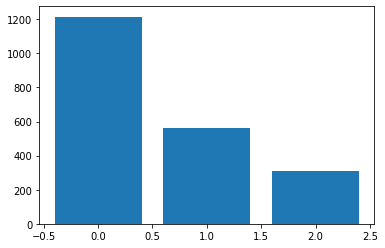

In [37]:
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)
print(cls, count)

# Build Transfer Learning Model

In [38]:
# clear graph
tf.keras.backend.clear_session()  # 清內存，和避免層數堆疊

######**Resets all state generated by Keras.**
################
###### Keras manages a global state, which it uses to implement the Functional model-building API and to uniquify autogenerated layer names.

###### If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it. Calling **clear_session()** releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.
######Example 1: calling clear_session() when creating models in a loop
###### Example 2: resetting the layer name generation counter

## Model 1 :

In [39]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)

# Freeze layers 凍結層 把遷移來的卷積的參數固定
for l in base_model.layers:
  l.trainable = False

# 把卷積和後面的分類層合在一起
model = models.Model(base_model.input, predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

# Model 2 : 
###Extract features from an arbitrary intermediate layer with EfficientNet

In [40]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3) 
)

# get layer by name
features = base_model.get_layer('block2a_expand_conv').output
# get layer by layer index
# feature = base_model.layers[17].output

x = layers.GlobalAveragePooling2D()(features)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = models.Model(base_model.input, predictions)

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

# Preapre Data

#### split dataset

In [42]:
path_train, path_val = train_test_split(paths, test_size=0.2)
len(path_train), len(path_val)

(1668, 418)

######tqdm ，也是阿拉伯語當中的『進度條』的意思。只需要安裝這個模組，我們就可以在任何需要迭代的地方使用 tqdm 來顯示進度。

In [43]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
  num_data = len(paths)  # 資料的數量
  x_data = np.empty((num_data, img_size, img_size, 3))
  y_data = np.empty((num_data))

  for i, path, in enumerate(tqdm(paths)):
    # read image and preprocess
    img = cv2.imread(path)[:, :, ::-1]
    img = cv2.resize(img, (img_size, img_size))
    
    # # # preprocess by histogram equalization
    # img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # y, cr, cb = cv2.split(img_y_cr_cb)
    # # # Applying equalize Hist operation on Y channel.
    # y_eq = cv2.equalizeHist(y)
    # img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
    # img = cv2.cvtColor(img_y_cr_b_eq, cv2.COLOR_YCR_CB2RGB)

    # !!!!!!!!! Use model preprocessing function !!!!!!!!
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    x_data[i] = img

    if not test:
      # read class label
      filename = os.path.split(path)[1]
      cls = int(filename.split('.')[0].split('_')[-1])
      y_data[i] = cls
  if not test:
    y_data = utils.to_categorical(y_data, num_classes=num_classes) # one-hot-encoding 
    return x_data, y_data
  else:
    x_data

In [44]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:04<00:00, 114.51it/s]


In [45]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

# Trainung

In [46]:
model.compile(
        optimizer = "adam",
        loss = losses.categorical_crossentropy,
        metrics = [metrics.categorical_accuracy]
)

In [48]:
logs = model.fit(x_train, y_train,
                 batch_size = 32,
                 epochs = 20, 
                 validation_data=(x_val, y_val)
                 )

Epoch 1/20
53/53 [==============================] - 64s 1s/step - loss: 0.8575 - categorical_accuracy: 0.6079 - val_loss: 1.1062 - val_categorical_accuracy: 0.5072
Epoch 2/20
53/53 [==============================] - 64s 1s/step - loss: 0.8652 - categorical_accuracy: 0.6019 - val_loss: 0.9651 - val_categorical_accuracy: 0.5837
Epoch 3/20
53/53 [==============================] - 64s 1s/step - loss: 0.8622 - categorical_accuracy: 0.6097 - val_loss: 1.4493 - val_categorical_accuracy: 0.2943
Epoch 4/20
53/53 [==============================] - 64s 1s/step - loss: 0.8580 - categorical_accuracy: 0.6115 - val_loss: 1.0147 - val_categorical_accuracy: 0.5646
Epoch 5/20
53/53 [==============================] - 64s 1s/step - loss: 0.8539 - categorical_accuracy: 0.6121 - val_loss: 0.9728 - val_categorical_accuracy: 0.5431
Epoch 6/20
53/53 [==============================] - 64s 1s/step - loss: 0.8565 - categorical_accuracy: 0.6055 - val_loss: 1.0455 - val_categorical_accuracy: 0.5622
Epoch 7/20
53/53

#Make Submission file
###### Kaggle: https://www.kaggle.com/c/retinopathy-classification-sai/data

In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df["Id"] = [p.split(os.sep)[-1] for p in paths_test]
df["Category"] = predictions
df.to_csv("submission.csv", index=None)
df